In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, signal, stats
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict as dd
import os

plt.style.use('seaborn-whitegrid')

In [133]:
dfs = []
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        
        # the gearbox state is in the filename prefix (h = healthy, b = broken tooth)
        state = filename[0]
        
        # the load is in the filename suffix
        load = int(filename.split('.')[0][5:])
        
        # read in the file
        df = pd.read_csv(os.path.join(dirname, filename))
        
        # include the healthy/broken state
        df['state'] = state
        
        # include the load
        df['load'] = load  
        # append to a list
        dfs.append(df)


# concatenate all the datasets and reset the index
df = pd.concat(dfs).reset_index().rename(columns={'index':'sample_index'})

In [137]:
df["state"].replace({"b": 1, "h": 0}, inplace=True)
tail = df.tail(10).to_dict()

{'sample_index': {2021109: 106742,
  2021110: 106743,
  2021111: 106744,
  2021112: 106745,
  2021113: 106746,
  2021114: 106747,
  2021115: 106748,
  2021116: 106749,
  2021117: 106750,
  2021118: 106751},
 'a1': {2021109: -10.8023,
  2021110: 13.9087,
  2021111: 6.37438,
  2021112: -15.2817,
  2021113: 3.13954,
  2021114: 0.677448,
  2021115: -10.5754,
  2021116: -4.03329,
  2021117: 1.86867,
  2021118: 7.58148},
 'a2': {2021109: -5.15393,
  2021110: 7.88091,
  2021111: -3.59342,
  2021112: 3.73856,
  2021113: 6.8219,
  2021114: -3.23441,
  2021115: 7.7254,
  2021116: 2.57692,
  2021117: -5.0894,
  2021118: 6.20596},
 'a3': {2021109: 6.84189,
  2021110: -2.98886,
  2021111: 0.590603,
  2021112: 4.00437,
  2021113: -2.92981,
  2021114: -1.72599,
  2021115: -2.18401,
  2021116: 1.46843,
  2021117: 5.34229,
  2021118: -6.12133},
 'a4': {2021109: -3.60985,
  2021110: 6.41759,
  2021111: 2.61505,
  2021112: 1.52184,
  2021113: 1.55903,
  2021114: -3.14302,
  2021115: 2.56965,
  2021116: 2

In [109]:
sensor_readings = df.melt(
    id_vars=['state','load'],
    value_vars=['a1','a2','a3','a4'],
    var_name='sensor',
    value_name='reading'
)

<AxesSubplot:xlabel='count', ylabel='load'>

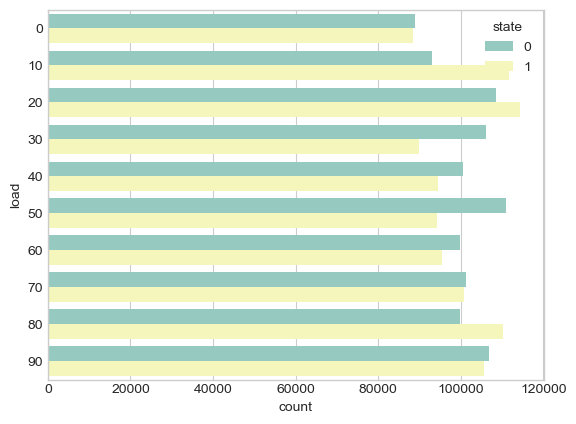

In [110]:
sns.countplot(
    data=sensor_readings[sensor_readings.sensor=='a1'],
    y='load',
    hue='state',
)

In [111]:
# helper function to filter the dataset
def rdg(df, state=None, load=None, sensor=None):
    df_st = df[df.state==state] if state is not None else df
    df_lo = df_st[df_st.load==load] if load is not None else df_st
    df_se = df_lo[df_lo.sensor==sensor] if sensor is not None else df_lo
    return df_se

In [112]:
sensor_readings

state  load sensor    reading
0            1     0     a1   2.350390
1            1     0     a1   2.452970
2            1     0     a1  -0.241284
3            1     0     a1   1.130270
4            1     0     a1  -1.296140
...        ...   ...    ...        ...
8084471      0    90     a4  -3.143020
8084472      0    90     a4   2.569650
8084473      0    90     a4   2.728910
8084474      0    90     a4  -1.365630
8084475      0    90     a4  11.548300

[8084476 rows x 4 columns]

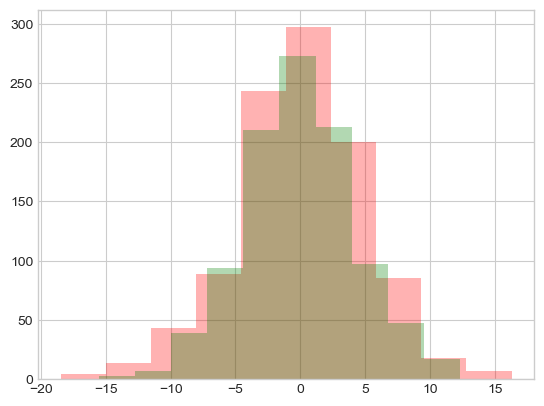

In [113]:
plt.hist(rdg(sensor_readings, 1, 90, 'a2').reading.values[:1000], color='r', alpha=0.3) # broken tooth
plt.hist(rdg(sensor_readings, 0, 90, 'a2').reading.values[:1000], color='g', alpha=0.3) # healthy
plt.show()

In [114]:
data = []
labels = []
i=0
j=0
for (state,load,sensor),g in sensor_readings.groupby(['state','load','sensor']):
    vals = g.reading.values
    # if(j==0):
    #   print(vals)
    #   print(len(vals))
    #   j+=1
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    # if(i==0):
    #   print(len(splits))
    #   i+=1
    for s in splits[:-1]:  # except the last one
        data.append({
            'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state==1))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
# labels[0:10]
(data.shape, labels.shape)

((8036, 9), (8036,))

In [115]:
print(f'Total samples: {len(labels)}')
print(f'Healthy class: {np.sum(labels)} ({np.sum(labels)/len(labels):0.1%})')

Total samples: 8036
Healthy class: 4000 (49.8%)


In [116]:
sensor_readings

state  load sensor    reading
0            1     0     a1   2.350390
1            1     0     a1   2.452970
2            1     0     a1  -0.241284
3            1     0     a1   1.130270
4            1     0     a1  -1.296140
...        ...   ...    ...        ...
8084471      0    90     a4  -3.143020
8084472      0    90     a4   2.569650
8084473      0    90     a4   2.728910
8084474      0    90     a4  -1.365630
8084475      0    90     a4  11.548300

[8084476 rows x 4 columns]

In [117]:
df_data

sensor_a1  sensor_a2  sensor_a3  load      mean       std      kurt  \
0             1          0          0     0 -0.021091  5.547919  2.626183   
1             1          0          0     0 -0.012301  6.201618  3.640234   
2             1          0          0     0 -0.071201  5.110114  3.554958   
3             1          0          0     0 -0.031611  5.793023  1.543246   
4             1          0          0     0 -0.039073  6.103405  2.166403   
...         ...        ...        ...   ...       ...       ...       ...   
8031          0          0          0    90 -0.366604  5.024477  0.529363   
8032          0          0          0    90  0.313392  4.536299  0.608074   
8033          0          0          0    90  0.209249  5.286125  1.005567   
8034          0          0          0    90 -0.111464  5.056349  0.311987   
8035          0          0          0    90  0.276615  5.777956  0.527905   

          skew  moment  
0     0.025210     0.0  
1    -0.047139     0.0  
2    -0.154070     0.0  
3    -0.043227     0.0  
4     0.058691     0.0  
...        ...     ...  
8031 -0.154551     0.0  
8032 -0.176003     0.0  
8033 -0.036180     0.0  
8034 -0.224558     0.0  
8035 -0.099504     0.0  

[8036 rows x 9 columns]

In [118]:
cols_to_scale = ['load','mean','std','kurt','skew','moment']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_data[cols_to_scale] = scaler.fit_transform(df_data[cols_to_scale])

In [119]:
df_data

sensor_a1  sensor_a2  sensor_a3  load      mean       std      kurt  \
0             1          0          0   0.0  0.692549  0.367609  0.348919   
1             1          0          0   0.0  0.697601  0.447938  0.479114   
2             1          0          0   0.0  0.663755  0.313810  0.468165   
3             1          0          0   0.0  0.686504  0.397728  0.209880   
4             1          0          0   0.0  0.682216  0.435869  0.289887   
...         ...        ...        ...   ...       ...       ...       ...   
8031          0          0          0   1.0  0.494006  0.303286  0.079706   
8032          0          0          0   1.0  0.884755  0.243297  0.089812   
8033          0          0          0   1.0  0.824911  0.335439  0.140847   
8034          0          0          0   1.0  0.640618  0.307203  0.051797   
8035          0          0          0   1.0  0.863622  0.395877  0.079519   

          skew  moment  
0     0.527525     0.0  
1     0.488238     0.0  
2     0.430171     0.0  
3     0.490362     0.0  
4     0.545707     0.0  
...        ...     ...  
8031  0.429910     0.0  
8032  0.418261     0.0  
8033  0.494189     0.0  
8034  0.391894     0.0  
8035  0.459802     0.0  

[8036 rows x 9 columns]

In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_data, labels,
    train_size=0.8,
    random_state=42,
    # stratify=labels
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}')

Training data: (6428, 9)
Test data: (1608, 9)


In [121]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(10, input_dim=4, activation=tf.nn.relu, kernel_initializer='he_normal', 
#                                 kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(7, activation=tf.nn.relu, kernel_initializer='he_normal', 
#                                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(5, activation=tf.nn.relu, kernel_initializer='he_normal', 
#                                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)))
# model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [122]:
# import tensorflow as tf
# from tensorflow import keras

# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(100, input_shape=(9,), activation=tf.nn.relu))
# # model.add(tf.keras.layers.BatchNormalization())# ----------------
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(50, activation=tf.nn.relu))
# # model.add(tf.keras.layers.BatchNormalization()) # ---------------
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(25, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(12, activation=tf.nn.softmax))
# model.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax))
# model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))
# model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [123]:
model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(9,), activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [124]:
epoch = 7
history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, verbose=0)

In [125]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [126]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 0s 4ms/step - loss: 0.4851 - accuracy: 0.7929


[0.4850931763648987, 0.7929104566574097]

In [127]:
model.save(f'model_{epoch}_k.h5', save_format='h5', include_optimizer=True, overwrite=True, save_traces=True)

In [128]:
print(model.losses)

[]


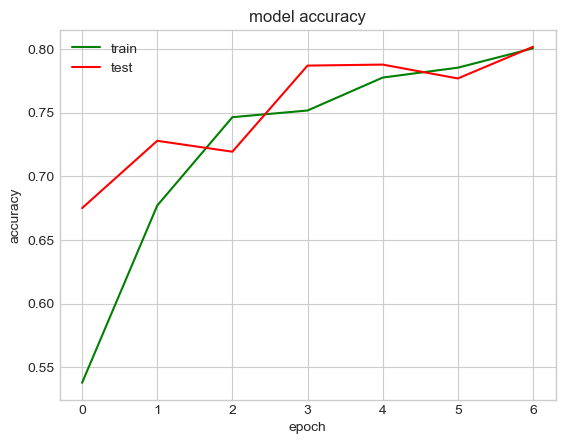

In [129]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], label='train', color='g')
plt.plot(history.history['val_accuracy'], color='r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


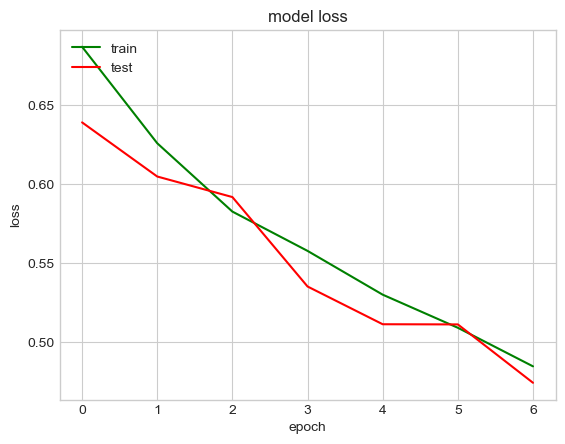

In [130]:
# summarize history for loss
plt.plot(history.history['loss'], color='g')
plt.plot(history.history['val_loss'], color='r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [131]:
# import tensorflow as tf
# from tensorflow import keras


# model = keras.Sequential([
#     keras.layers.Dense(100, input_shape=(9,), activation='relu'),
#     keras.layers.Dense(50, activation='relu'),
#     keras.layers.Dense(25, activation='relu'),
#     keras.layers.Dense(12, activation='relu'),
#     keras.layers.Dense(6, activation='relu'),
#     keras.layers.Dense(3, activation='relu'),
#     keras.layers.Dense(1, activation='sigmoid')
# ])

# # opt = keras.optimizers.Adam(learning_rate=0.01)

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=100)